# ResNet50 (pretrained on ImageNET) on CIFAR10



In [8]:
network_names = [ 'incv3', 'resnet50', 'vgg16', 'vgg19' ]

print("Available networks = ", network_names)
cnnid = 1; 
# Hardcoded ResNET50 network for this project .
selected_network = network_names[cnnid]
print("Selected network: ", selected_network)

Available networks =  ['incv3', 'resnet50', 'vgg16', 'vgg19']
Selected network:  resnet50


In [9]:
import time
import numpy as np
import tensorflow as tf
from keras.layers import Input, Dense, AveragePooling2D, GlobalAveragePooling2D
from keras import backend as K

Using TensorFlow backend.


# Load CIFAR10 data


170500096/170498071 [==============================] - 8s 0us/step
(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)


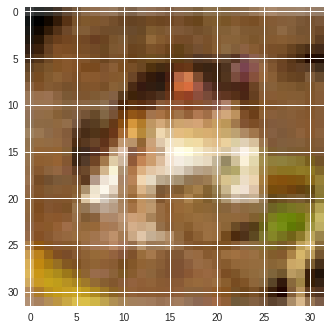

In [10]:
n_classes = 10
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

n_training = X_train.shape[0]
n_testing = X_test.shape[0]

y_train = y_train.flatten()
y_test  = y_test.flatten()

print( X_train.shape, y_train.shape,  X_test.shape, y_test.shape )

from matplotlib import pyplot as plt
plt.imshow( X_train[0]  )
plt.show()

# Creating model

In [0]:
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50     import ResNet50
from keras.applications.vgg16        import VGG16
from keras.applications.vgg19        import VGG19

input_shape = {
    'incv3'   : (299,299,3),
    'resnet50': (224,224,3),
    'vgg16'   : (224,224,3),
    'vgg19'   : (224,224,3)
}[selected_network]

def create_model_incv3():
    tf_input = Input(shape=input_shape)
    base_model = InceptionV3(input_tensor=tf_input, weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return base_model, model

def create_model_resnet50():
    tf_input = Input(shape=input_shape)
    base_model = ResNet50(input_tensor=tf_input, include_top=False) #We dont include the top layers so that we can fine tune the network according to our dataset
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return base_model, model

# TODO: build all the rest :-)
def create_model_vgg16():
    tf_input = Input(shape=input_shape)
    model = VGG16(input_tensor=tf_input, include_top=False)
    output_pooled = AveragePooling2D((7, 7))(model.output)
    return Model(model.input, output_pooled )

def create_model_vgg19():
    tf_input = Input(shape=input_shape)
    model = VGG19(input_tensor=tf_input, include_top=False)
    output_pooled = AveragePooling2D((7, 7))(model.output)
    return Model(model.input, output_pooled )

create_model = {
    'incv3'    : create_model_incv3,
    'resnet50' : create_model_resnet50,
    'vgg16'    : create_model_vgg16,
    'vgg19'    : create_model_vgg19
}[selected_network]

# Data generator for tensorflow



In [0]:
# tensorflow placeholder for batch of images from CIFAR10 dataset
batch_of_images_placeholder = tf.placeholder("uint8", (None, 32, 32, 3))

batch_size = {
    'incv3'    : 16,
    'resnet50' : 16,
    'vgg16'    : 16,
    'vgg19'    : 16
}[selected_network]


tf_resize_op = tf.image.resize_images(batch_of_images_placeholder, (input_shape[:2]), method=0)

In [0]:
# data generator for tensorflow session
from keras.applications.inception_v3 import preprocess_input as incv3_preprocess_input
from keras.applications.resnet50     import preprocess_input as resnet50_preprocess_input
from keras.applications.vgg16        import preprocess_input as vgg16_preprocess_input
from keras.applications.vgg19        import preprocess_input as vgg19_preprocess_input

preprocess_input = {
    'incv3'   : incv3_preprocess_input,
    'resnet50': resnet50_preprocess_input,
    'vgg16'   : vgg16_preprocess_input,
    'vgg19'   : vgg19_preprocess_input
}[selected_network]

def data_generator(sess,data,labels):
    def generator():
        start = 0
        end = start + batch_size
        n = data.shape[0]
        while True:
            batch_of_images_resized = sess.run(tf_resize_op, {batch_of_images_placeholder: data[start:end]})
            batch_of_images__preprocessed = preprocess_input(batch_of_images_resized)
            batch_of_labels = labels[start:end]
            
            start += batch_size
            end   += batch_size
            if start >= n:
                start = 0
                end = batch_size
            yield (batch_of_images__preprocessed, batch_of_labels)
    return generator

# Creating the model

In [0]:
sess = tf.InteractiveSession()

In [0]:
K.set_session(sess)
K.set_learning_phase(1) 

In [16]:
base_model, model = create_model()

94658560/94653016 [==============================] - 4s 0us/step


In [17]:
# Visualizing layer names and layer indices to see how many layers we should freeze
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_1
1 conv1_pad
2 conv1
3 bn_conv1
4 activation_1
5 max_pooling2d_1
6 res2a_branch2a
7 bn2a_branch2a
8 activation_2
9 res2a_branch2b
10 bn2a_branch2b
11 activation_3
12 res2a_branch2c
13 res2a_branch1
14 bn2a_branch2c
15 bn2a_branch1
16 add_1
17 activation_4
18 res2b_branch2a
19 bn2b_branch2a
20 activation_5
21 res2b_branch2b
22 bn2b_branch2b
23 activation_6
24 res2b_branch2c
25 bn2b_branch2c
26 add_2
27 activation_7
28 res2c_branch2a
29 bn2c_branch2a
30 activation_8
31 res2c_branch2b
32 bn2c_branch2b
33 activation_9
34 res2c_branch2c
35 bn2c_branch2c
36 add_3
37 activation_10
38 res3a_branch2a
39 bn3a_branch2a
40 activation_11
41 res3a_branch2b
42 bn3a_branch2b
43 activation_12
44 res3a_branch2c
45 res3a_branch1
46 bn3a_branch2c
47 bn3a_branch1
48 add_4
49 activation_13
50 res3b_branch2a
51 bn3b_branch2a
52 activation_14
53 res3b_branch2b
54 bn3b_branch2b
55 activation_15
56 res3b_branch2c
57 bn3b_branch2c
58 add_5
59 activation_16
60 res3c_branch2a
61 bn3c_branch2a
62 activatio

In [18]:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_1
1 conv1_pad
2 conv1
3 bn_conv1
4 activation_1
5 max_pooling2d_1
6 res2a_branch2a
7 bn2a_branch2a
8 activation_2
9 res2a_branch2b
10 bn2a_branch2b
11 activation_3
12 res2a_branch2c
13 res2a_branch1
14 bn2a_branch2c
15 bn2a_branch1
16 add_1
17 activation_4
18 res2b_branch2a
19 bn2b_branch2a
20 activation_5
21 res2b_branch2b
22 bn2b_branch2b
23 activation_6
24 res2b_branch2c
25 bn2b_branch2c
26 add_2
27 activation_7
28 res2c_branch2a
29 bn2c_branch2a
30 activation_8
31 res2c_branch2b
32 bn2c_branch2b
33 activation_9
34 res2c_branch2c
35 bn2c_branch2c
36 add_3
37 activation_10
38 res3a_branch2a
39 bn3a_branch2a
40 activation_11
41 res3a_branch2b
42 bn3a_branch2b
43 activation_12
44 res3a_branch2c
45 res3a_branch1
46 bn3a_branch2c
47 bn3a_branch1
48 add_4
49 activation_13
50 res3b_branch2a
51 bn3b_branch2a
52 activation_14
53 res3b_branch2b
54 bn3b_branch2b
55 activation_15
56 res3b_branch2c
57 bn3b_branch2c
58 add_5
59 activation_16
60 res3c_branch2a
61 bn3c_branch2a
62 activatio

In [0]:
#   first we will train only the top layers (which were randomly initialized)
#   i.e. freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# compiling the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [0]:
y_train_one_hot = tf.one_hot( y_train, n_classes ).eval() #Creating one hot encoded vectors for y_train

In [0]:
data_train_gen = data_generator(sess, X_train, y_train_one_hot )

In [22]:
# Now we will train the model for one epoch(default value)
model.fit_generator(data_train_gen(), 100, verbose=1)

Epoch 1/1
100/100 [==============================] - 19s 188ms/step - loss: 3.4022


## Model Validation

In [0]:
images_resized = sess.run(tf_resize_op, {batch_of_images_placeholder: X_test})
images = preprocess_input(images_resized)

In [30]:
result = model.predict(images, verbose=1)

10000/10000 [==============================] - 4911s 491ms/step


In [0]:
y_pred = [ np.argmax( result[i] ) for i in range(n_testing) ]

In [32]:
np.sum( y_pred == y_test ) / n_testing

0.7036

# Even for one epoch we got 70% accuracy

## Train more layers

In [0]:
# The top layers are well trained and we can start fine-tuning convolutional layers .
# We will freeze the bottom N layers and train the remaining top layers.

In [0]:
for layer in model.layers[:16]:
   layer.trainable = False
for layer in model.layers[16:]:
   layer.trainable = True

In [0]:
# We need to recompile the model for these modifications to take effect
# We use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

In [27]:
# We train our model again alongside the top Dense layers
model.fit_generator(data_train_gen(), 500, epochs=10, verbose=1)

Epoch 1/10
500/500 [==============================] - 229s 458ms/step - loss: 0.4655
Epoch 2/10
374/500 [=====================>........] - ETA: 57s - loss: 0.4785500/500 [==============================] - 229s 458ms/step - loss: 0.4717
Epoch 3/10
500/500 [==============================] - 230s 460ms/step - loss: 0.4112
Epoch 4/10
 65/500 [==>...........................] - ETA: 3:20 - loss: 0.3788500/500 [==============================] - 229s 457ms/step - loss: 0.3535
Epoch 5/10
466/500 [==========================>...] - ETA: 15s - loss: 0.3483500/500 [==============================] - 227s 453ms/step - loss: 0.3493
Epoch 6/10
500/500 [==============================] - 227s 454ms/step - loss: 0.3136
Epoch 7/10
 91/500 [====>.........................] - ETA: 3:06 - loss: 0.2975500/500 [==============================] - 227s 454ms/step - loss: 0.2297
Epoch 8/10
478/500 [===========================>..] - ETA: 9s - loss: 0.2099 500/500 [==============================] - 227s 453ms/step - l

## Validating tuned network

In [29]:
result = model.predict(images, verbose=1)
y_pred = [ np.argmax( result[i] ) for i in range(n_testing) ]
np.sum( y_pred == y_test ) / n_testing

10000/10000 [==============================] - 93s 9ms/step


0.9174

So we obtained ***91.74%*** on testing dataset.
We can increase our accuracy by increasing the number of iterations and/or epochs

# Feature extraction

In [0]:
from keras.models import load_model
base_model.save('{network}-tuned.h5'.format(network=selected_network))

In [0]:
from keras.models import load_model
model.save('model/{network}-full-tuned.h5'.format(network=selected_network))

In [0]:
model_tuned = base_model

In [0]:
def Xdata_generator(sess,data):
    def generator():
        start = 0
        end = start + batch_size
        n = data.shape[0]
        while True:
            batch_of_images_resized = sess.run(tf_resize_op, {batch_of_images_placeholder: data[start:end]})
            batch_of_images__preprocessed = preprocess_input(batch_of_images_resized)
            
            start += batch_size
            end   += batch_size
            if start >= n:
                start = 0
                end = batch_size
            yield batch_of_images__preprocessed
    return generator

In [0]:
Xdata_train_gen = Xdata_generator(sess, X_train)

In [35]:
ftrs_training = model_tuned.predict_generator(Xdata_train_gen(), n_training/batch_size, verbose=1)

3125/3125 [==============================] - 505s 162ms/step


In [0]:
Xdata_test_gen = Xdata_generator(sess, X_test)

In [37]:
ftrs_testing = model_tuned.predict_generator(Xdata_test_gen(), n_testing/batch_size, verbose=1)

625/625 [==============================] - 100s 161ms/step


In [0]:
sess.close()

In [39]:
ftrs_training.shape

(50000, 1, 1, 2048)

In [40]:
ftrs_testing.shape

(10000, 1, 1, 2048)

In [0]:
features_training = np.array( [ftrs_training[i].flatten() for i in range(n_training)] )
features_testing  = np.array( [ftrs_testing[i].flatten()  for i in range(n_testing )] )

np.savez_compressed("CIFAR10_{}-tuned-keras_features.npz".format(selected_network), \
                    features_training=features_training, \
                    features_testing=features_testing,   \
                    labels_training=y_train,             \
                    labels_testing=y_test)

In [43]:
features_training.shape, features_testing.shape

((50000, 2048), (10000, 2048))

In [44]:
print('Ten first features of X_train[0] (see figure above, with the frog)')
features_training[0][0:10]

Ten first features of X_train[0] (see figure above, with the frog)


array([0.11102374, 0.09464992, 0.8439637 , 0.20044054, 1.577852  ,
       0.30814397, 0.28472072, 0.00540198, 0.15459213, 0.06598022],
      dtype=float32)

# Feature visualization

Here we visualize the features extracted by the pretrained CNN network.

## Feature analysis (using PCA)

In [47]:
import numpy as np


data = np.load("CIFAR10_{}-tuned-keras_features.npz".format(selected_network))

X_training = data['features_training']
y_training = data['labels_training']

X_testing = data['features_testing']
y_testing = data['labels_testing']

print( 'X_training size = {}'.format(X_training.shape))

X_training size = (50000, 2048)


In [48]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
pca.fit(X_training)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [49]:
print(pca.explained_variance_ratio_)

[0.06830782 0.04082434]


In [0]:
X = pca.transform(X_training)

In [51]:
X.shape

(50000, 2)

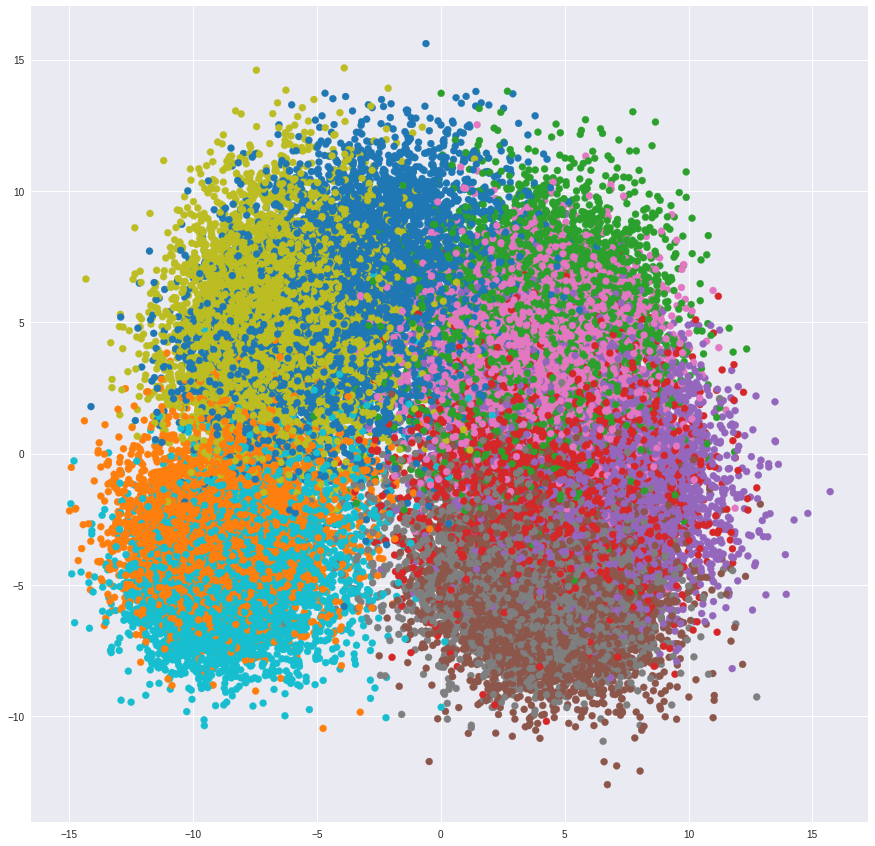

In [52]:
from matplotlib import pyplot as plt
plt.figure( figsize=(15,15) )
plt.scatter( X[:, 0], X[:, 1], c=y_training, cmap='tab10' )
plt.show()

## Feature analysis using t-SNE

In [0]:
from sklearn.manifold import TSNE
pca = decomposition.PCA(n_components=50)
X_training_reduced = pca.fit_transform(X_training)

Since t-SNE is quite complex, so we compress the data.

In [58]:
np.sum( pca.explained_variance_ratio_ )

0.5509663

In [0]:
tsne = TSNE(n_components=2)

In [0]:
X_training_reduced_tsne = tsne.fit_transform(X_training_reduced)

In [61]:
X_training_reduced_tsne.shape

(50000, 2)

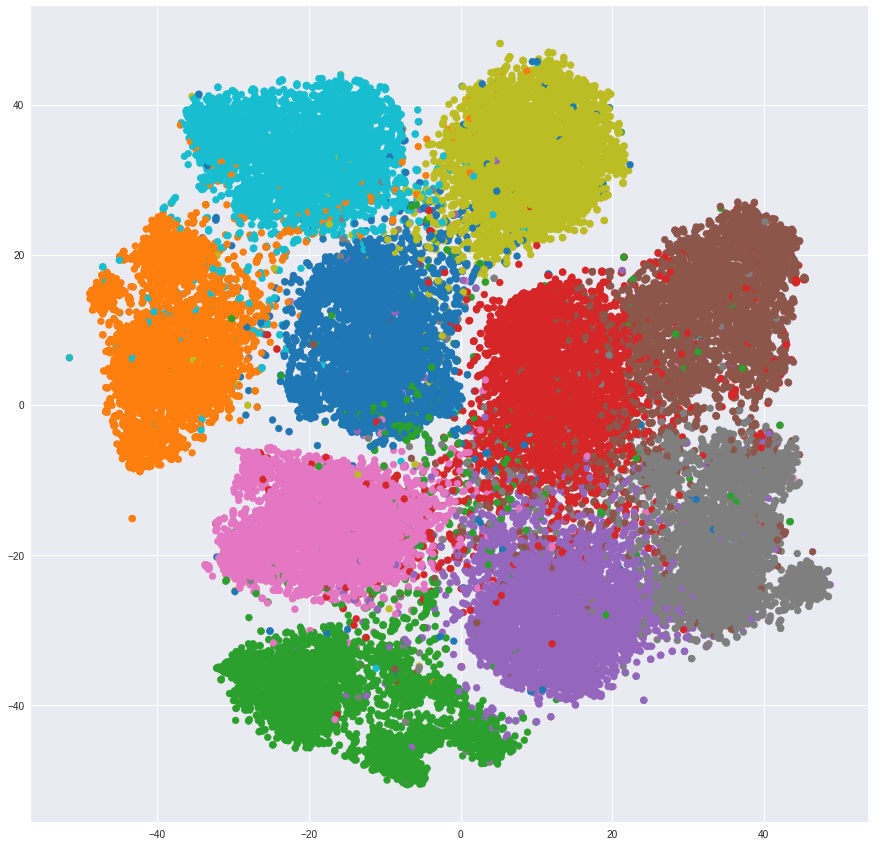

In [62]:
plt.figure( figsize=(15,15) )
plt.scatter( X_training_reduced_tsne[:, 0], X_training_reduced_tsne[:, 1], c=y_training, cmap='tab10' )
plt.show()

In [0]:
# t-SNE does a better job than PCA to seggregate the classes

# Thus we saw how Transfer Learning can facilitate in model building to achieve good accuracy with computation and time constraints.